In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%cd ../..

/Users/kristophermiltiadou/Documents/UniWork/Cambridge/Thesis/CODE/new_iREC


In [4]:
import torch
import hamiltorch
import matplotlib.pyplot as plt
import pyro.distributions as dist
import torch.distributions as D
import torch.nn as nn
import torch.nn.functional as F

device  =torch.device('cpu')

In [5]:
%matplotlib inline

In [19]:
hamiltorch.__version__

'0.4.0.dev1'

In [ ]:
from sklearn.datasets import load_boston
import numpy as np

data = load_boston()

x_ = data['data']
y_ = data['target']
N_tr = int(x_.shape[0] * 0.5)
N_val = x_.shape[0] - N_tr
a = np.arange(x_.shape[0])
train_index = np.random.choice(a, size = N_tr, replace = False)
val_index = np.delete(a, train_index, axis=0)
x_train = x_[train_index]
y_train = y_[train_index].reshape(-1, 1)
x_m = x_train.mean(0)
x_s = x_train.std(0)
x_train = (x_train-x_m)/ x_s
x_val = x_[val_index][:]
y_val = y_[val_index][:].reshape(-1, 1)
x_val = (x_val-x_m)/ x_s
D_in = x_train.shape[1]
x_train = torch.FloatTensor(x_train)
y_train = torch.FloatTensor(y_train)
x_val = torch.FloatTensor(x_val)
y_val = torch.FloatTensor(y_val)
plt.scatter(x_train.numpy()[:,0],y_train.numpy())
    
x_train = x_train.to(device)
y_train = y_train.to(device)
x_val = x_val.to(device)
y_val = y_val.to(device)

In [ ]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# if torch.cuda.is_available():
#     print(torch.cuda.get_device_name(0))

device=torch.device('cpu')
class Net(nn.Module):
    def __init__(self, num_nodes: int = 10):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(13, num_nodes)
        self.fc2 = nn.Linear(num_nodes, num_nodes)
        self.fc3 = nn.Linear(num_nodes, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

num_nodes = 50
alpha = 1.
beta = 100.
ELBO_BETA = 1.
net = Net(num_nodes=num_nodes)

In [86]:
step_size = 1e-3

num_samples = 10000
L = 5
burn = 5000
store_on_GPU = False
debug = False
model_loss = 'regression'
mass = 1.0

# Effect of tau
# Set to tau = 1000. to see a function that is less bendy (weights restricted to small bends)
# Set to tau = 1. for more flexible

tau = alpha # Prior Precision
tau_out = beta * 1/ELBO_BETA # Output Precision
r = 1000 # Random seed


tau_list = []
for w in net.parameters():
    tau_list.append(tau) # set the prior precision to be the same for each set of weights
tau_list = torch.tensor(tau_list).to(device)

# Set initial weights
params_init = hamiltorch.util.flatten(net).to(device).clone()
# Set the Inverse of the Mass matrix
inv_mass = torch.ones(params_init.shape) / mass

In [87]:
print(params_init.shape)
integrator = hamiltorch.Integrator.EXPLICIT
sampler = hamiltorch.Sampler.HMC_NUTS

hamiltorch.set_random_seed(r)
params_hmc_f = hamiltorch.sample_model(net, x_train.to(device), y_train.to(device), params_init=params_init,
                                       model_loss=model_loss, num_samples=num_samples,
                                       burn = burn, inv_mass=inv_mass.to(device),step_size=step_size,
                                       num_steps_per_sample=L,tau_out=tau_out, tau_list=tau_list,
                                       debug=debug, store_on_GPU=store_on_GPU,
                                       sampler = sampler, integrator=integrator)

# At the moment, params_hmc_f is on the CPU so we move to GPU

params_hmc_gpu = [ll.to(device) for ll in params_hmc_f[1:]]




torch.Size([3301])
Sampling (Sampler.HMC; Integrator.EXPLICIT)
Time spent  | Time remain.| Progress             | Samples     | Samples/sec


KeyboardInterrupt: 

In [79]:
pred_list_hmc, log_probs_f = hamiltorch.predict_model(net, x = x_train.to(device),
                                                  y = y_train.to(device), samples=params_hmc_gpu,
                                                  model_loss=model_loss, tau_out=beta,
                                                  tau_list=tau_list)

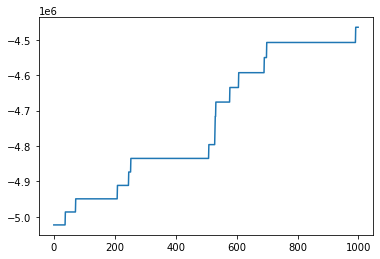

In [80]:
plt.plot(log_probs_f[-1000:])

In [81]:
# Let's predict over the entire test range [-2,2]
pred_list_hmc, log_probs_f = hamiltorch.predict_model(net, x = x_val.to(device),
                                                  y = y_val.to(device), samples=params_hmc_gpu,
                                                  model_loss=model_loss, tau_out=beta,
                                                  tau_list=tau_list)

In [82]:
pred_list_hmc[-1]

tensor([[437.2684],
        [403.0728],
        [386.7837],
        [390.5259],
        [459.4637],
        [457.2155],
        [451.2189],
        [456.9491],
        [454.9436],
        [440.9226],
        [443.6459],
        [441.3521],
        [444.7716],
        [386.5075],
        [443.2302],
        [445.2063],
        [407.1714],
        [442.5841],
        [436.0824],
        [444.3894],
        [429.1201],
        [415.6090],
        [405.1211],
        [403.8068],
        [375.9648],
        [389.9141],
        [392.9860],
        [406.1201],
        [412.2848],
        [394.2310],
        [582.8681],
        [451.4934],
        [418.1205],
        [426.4171],
        [431.5228],
        [461.5383],
        [466.8603],
        [465.0750],
        [422.2428],
        [426.7513],
        [506.0716],
        [505.6515],
        [429.4015],
        [404.2358],
        [403.6180],
        [405.9090],
        [428.0786],
        [419.1961],
        [422.3844],
        [428.0546],


# Draw subset of samples

In [165]:
import random
random.seed(0)
subset = random.sample(params_hmc_gpu[-5000:], 1000)
# Let's predict over the entire test range [-2,2]
pred_list_hmc_subsample, log_probs_f = hamiltorch.predict_model(net, x = x_val.to(device),
                                                  y = x_val.to(device), samples=subset,
                                                  model_loss=model_loss, tau_out=tau_out,
                                                  tau_list=tau_list)

In [167]:
emp_samples = torch.empty([0])
for s in subset:
    emp_samples = torch.cat([emp_samples, s[None]])

In [168]:
prior = D.MultivariateNormal(loc=torch.zeros_like(emp_samples[0]), covariance_matrix = 1./alpha * torch.eye(emp_samples.shape[-1]))
prior.log_prob(emp_samples).median()

/scratch/km817/miniconda3/envs/Torch/lib/python3.8/site-packages/pyro/distributions/torch_patch.py:81: UserWarning: torch.symeig is deprecated in favor of torch.linalg.eigh and will be removed in a future PyTorch release.
The default behavior has changed from using the upper triangular portion of the matrix by default to using the lower triangular portion.
L, _ = torch.symeig(A, upper=upper)
should be replaced with
L = torch.linalg.eigvalsh(A, UPLO='U' if upper else 'L')
and
L, V = torch.symeig(A, eigenvectors=True)
should be replaced with
L, V = torch.linalg.eigh(A, UPLO='U' if upper else 'L') (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:2500.)
  return torch.stack([v.symeig(eigenvectors=False)[0][:1] > 0.0


tensor(-407.8339)

###### Let's try the KDE coder

In [169]:
from rec.beamsearch.distributions.CodingSampler import CodingSampler
from rec.beamsearch.distributions.KDEPosterior import KDEPosterior
from rec.beamsearch.samplers.GreedySampling import GreedySampler
from rec.beamsearch.Coders.Encoder_KDE import EncoderKDE

In [171]:
# find optimal kde_var
from models.BNNs.BNN_KDE import BNN_KDE

bnn_kde = BNN_KDE(emp_samples, alpha=alpha, beta=beta, kl_beta=ELBO_BETA)

num_epochs = 5000
num_parallel_samples = 128
optimiser = torch.optim.Adamax(bnn_kde.parameters(), lr=5e-2)
for i in range(num_epochs):
    optimiser.zero_grad()
    loss = -bnn_kde.elbo(x_train, y_train, num_parallel_samples)
    if i % 1000 == 0:
        print(f'The loss is: {loss.item():.5f}, val of var is: {torch.exp(bnn_kde.log_kde_std)[0].item() ** 2:.5f}')
    loss.backward()
    optimiser.step()

NameError: name 'chosen_emp_samples' is not defined

In [ ]:
KDE_var = torch.exp(bnn_kde.log_kde_std)[0].item() ** 2
#n_samples = 100
KDE_weights = dist.Categorical(torch.ones(emp_samples.shape[0]))
initial_seed = 0
torch.manual_seed(initial_seed)
KDE_components = dist.MultivariateNormal(loc=emp_samples,
                                         covariance_matrix=KDE_var * torch.eye(emp_samples.shape[-1]))

KDE_target = dist.MixtureSameFamily(KDE_weights, KDE_components)

In [ ]:
from rec.utils import kl_estimate_with_mc
prior = D.MultivariateNormal(loc=torch.zeros_like(emp_samples[0]), covariance_matrix = 1./alpha * torch.eye(emp_samples.shape[-1]))
kl_q_p = kl_estimate_with_mc(KDE_target, prior)
print(f"{kl_q_p}")

# Lets optimise the variances

In [ ]:
#lets compress some samples
#### sample weights with compression algorithm
from tqdm.notebook import trange
from rec.beamsearch.Coders.Encoder_Empirical import Encoder
from rec.beamsearch.distributions.CodingSampler import CodingSampler
from rec.beamsearch.distributions.EmpiricalMixturePosterior import EmpiricalMixturePosterior
from rec.beamsearch.samplers.GreedySampling_BNNs import GreedySampler
from models.BNNs.BNN_for_HMC import BNN_for_HMC
import pyro.distributions as dist

In [ ]:
dummy_model = BNN_for_HMC(alpha=alpha, beta=beta, num_nodes=num_nodes)

In [ ]:
# import pickle as pkl
# pkl.dump(emp_samples, open("PickledStuff/emp_samples.pkl", "wb"))
# pkl.dump(x_data, open("PickledStuff/x_data.pkl", "wb"))
# pkl.dump(y_data, open("PickledStuff/y_data.pkl", "wb"))
# pkl.dump(ys, open("PickledStuff/ys.pkl", "wb"))
# pkl.dump(xs, open("PickledStuff/xs.pkl", "wb"))

In [ ]:
emp_dist = dist.Empirical(emp_samples, log_weights=torch.ones(emp_samples.shape[0]))

In [ ]:
from rec.OptimisingVars.FinalJointOptimiser import FinalJointOptimiser
coding_sampler = CodingSampler
auxiliary_posterior = EmpiricalMixturePosterior
selection_sampler = GreedySampler
omega = 5
initial_seed = 0
beamwidth = 1
epsilon = 0.
dummy_encoder = Encoder(dummy_model,
                     x_data,
                     y_data,
                     emp_samples,
                     initial_seed,
                     coding_sampler,
                     selection_sampler,
                     auxiliary_posterior,
                     omega,
                     beamwidth,
                     epsilon=epsilon,
                     prior_var=1./alpha,
                     total_kl=kl_q_p)

z_sample = emp_dist.mean
omega = 5
n_trajectories = 64
n_auxiliaries = dummy_encoder.n_auxiliary
prior_var = 1./alpha
emp_opt = FinalJointOptimiser(z_sample, omega, n_auxiliaries, kl_q_p, n_trajectories, prior_var)
aux_vars = emp_opt.run_optimiser(epochs=5000)

# Let's use the EMP scheme

In [ ]:
coding_sampler = CodingSampler
auxiliary_posterior = EmpiricalMixturePosterior
selection_sampler = GreedySampler
omega = 5

initial_seed = 0
beamwidth = 1
epsilon = 0.
num_compressed_samples = 50
compressed_weights_emp_low_eps = []

for i in trange(num_compressed_samples):
    initial_seed = initial_seed + i * 10
    encoder = Encoder(dummy_model,
                     x_data,
                     y_data,
                     emp_samples,
                     initial_seed,
                     coding_sampler,
                     selection_sampler,
                     auxiliary_posterior,
                     omega,
                     beamwidth,
                     epsilon=epsilon,
                     prior_var=1./alpha,
                     total_kl=kl_q_p)
    
    encoder.auxiliary_posterior.coding_sampler.auxiliary_vars = aux_vars
    
    w, idx = encoder.run_encoder()
    compressed_weights_emp_low_eps.append(w[0])

In [ ]:
pred_list_emp_low_eps, log_probs_f = hamiltorch.predict_model(net, x = xs.to(device),
                                                  y = ys.to(device), samples=compressed_weights_emp_low_eps,
                                                  model_loss=model_loss, tau_out=tau_out,
                                                  tau_list=tau_list)

plot_preds(pred_list_emp_low_eps)

In [ ]:
coding_sampler = CodingSampler
auxiliary_posterior = EmpiricalMixturePosterior
selection_sampler = GreedySampler
omega = 5

initial_seed = 0
beamwidth = 1
epsilon = 0.1
num_compressed_samples = 50
compressed_weights_emp_med_eps = []

for i in trange(num_compressed_samples):
    initial_seed = initial_seed + i * 10
    encoder = Encoder(dummy_model,
                     x_data,
                     y_data,
                     emp_samples,
                     initial_seed,
                     coding_sampler,
                     selection_sampler,
                     auxiliary_posterior,
                     omega,
                     beamwidth,
                     epsilon=epsilon,
                     prior_var=1./alpha,
                     total_kl=kl_q_p)
    
    encoder.auxiliary_posterior.coding_sampler.auxiliary_vars = aux_vars
    
    w, idx = encoder.run_encoder()
    compressed_weights_emp_med_eps.append(w[0])

pred_list_emp_med_eps, log_probs_f = hamiltorch.predict_model(net, x = xs.to(device),
                                                  y = xs.to(device), samples=compressed_weights_emp_med_eps,
                                                  model_loss=model_loss, tau_out=tau_out,
                                                  tau_list=tau_list)

plot_preds(pred_list_emp_med_eps)

In [ ]:
coding_sampler = CodingSampler
auxiliary_posterior = EmpiricalMixturePosterior
selection_sampler = GreedySampler
omega = 5

initial_seed = 0
beamwidth = 1
epsilon = 0.2
num_compressed_samples = 50
compressed_weights_emp_high_eps = []

for i in trange(num_compressed_samples):
    initial_seed = initial_seed + i * 10
    encoder = Encoder(dummy_model,
                     x_data,
                     y_data,
                     emp_samples,
                     initial_seed,
                     coding_sampler,
                     selection_sampler,
                     auxiliary_posterior,
                     omega,
                     beamwidth,
                     epsilon=epsilon,
                     prior_var=1./alpha,
                     total_kl=kl_q_p)
    
    encoder.auxiliary_posterior.coding_sampler.auxiliary_vars = aux_vars
    
    w, idx = encoder.run_encoder()
    compressed_weights_emp_high_eps.append(w[0])

pred_list_emp_high_eps, log_probs_f = hamiltorch.predict_model(net, x = xs.to(device),
                                                  y = xs.to(device), samples=compressed_weights_emp_high_eps,
                                                  model_loss=model_loss, tau_out=tau_out,
                                                  tau_list=tau_list)

plot_preds(pred_list_emp_high_eps)

# Let's try the KDE coder

In [ ]:
from rec.beamsearch.distributions.CodingSampler import CodingSampler
from rec.beamsearch.distributions.KDEPosterior import KDEPosterior
from rec.beamsearch.samplers.GreedySampling import GreedySampler
from rec.beamsearch.Coders.Encoder_KDE import EncoderKDE

In [ ]:
num_compressed_samples = 500
compressed_weights_kde_exact = []

for i in trange(num_compressed_samples):
    torch.manual_seed(i)
    compressed_weights_kde_exact.append(KDE_target.sample())

In [ ]:
pred_list_kde_exact, log_probs_f = hamiltorch.predict_model(net, x = xs.to(device),
                                                  y = xs.to(device), samples=compressed_weights_kde_exact,
                                                  model_loss=model_loss, tau_out=tau_out,
                                                  tau_list=tau_list)

plot_preds(pred_list_kde_exact)

In [ ]:
coding_sampler = CodingSampler
auxiliary_posterior = KDEPosterior
selection_sampler = GreedySampler
omega = 5

initial_seed = 0
beamwidth = 1
epsilon = 0.
num_compressed_samples = 50
compressed_weights_kde_low_eps = []

for i in trange(num_compressed_samples):
    initial_seed = initial_seed + i * 10
    encoder = EncoderKDE(KDE_target,
                        initial_seed,
                        coding_sampler,
                        selection_sampler,
                        auxiliary_posterior,
                        omega,
                        epsilon=epsilon,
                        beamwidth=beamwidth,
                        prior_var=1./alpha)
    
    encoder.auxiliary_posterior.coding_sampler.auxiliary_vars = aux_vars
    
    w, idx = encoder.run_encoder()
    compressed_weights_kde_low_eps.append(w[0])

In [ ]:
pred_list_kde_low_eps, log_probs_f = hamiltorch.predict_model(net, x = xs.to(device),
                                                  y = xs.to(device), samples=compressed_weights_kde_low_eps,
                                                  model_loss=model_loss, tau_out=tau_out,
                                                  tau_list=tau_list)

plot_preds(pred_list_kde_low_eps)


In [ ]:
coding_sampler = CodingSampler
auxiliary_posterior = KDEPosterior
selection_sampler = GreedySampler
omega = 5

initial_seed = 0
beamwidth = 1
epsilon = 0.1
num_compressed_samples = 50
compressed_weights_kde_med_eps = []

for i in trange(num_compressed_samples):
    initial_seed = initial_seed + i * 10
    encoder = EncoderKDE(KDE_target,
                        initial_seed,
                        coding_sampler,
                        selection_sampler,
                        auxiliary_posterior,
                        omega,
                        epsilon=epsilon,
                        beamwidth=beamwidth,
                        prior_var=1./alpha)
    
    encoder.auxiliary_posterior.coding_sampler.auxiliary_vars = aux_vars
    
    w, idx = encoder.run_encoder()
    compressed_weights_kde_med_eps.append(w[0])

In [ ]:
pred_list_kde_med_eps, log_probs_f = hamiltorch.predict_model(net, x = xs.to(device),
                                                  y = xs.to(device), samples=compressed_weights_kde_med_eps,
                                                  model_loss=model_loss, tau_out=tau_out,
                                                  tau_list=tau_list)

plot_preds(pred_list_kde_med_eps)


In [ ]:
coding_sampler = CodingSampler
auxiliary_posterior = KDEPosterior
selection_sampler = GreedySampler
omega = 5

initial_seed = 0
beamwidth = 1
epsilon = 0.2
num_compressed_samples = 50
compressed_weights_kde_high_eps = []

for i in trange(num_compressed_samples):
    initial_seed = initial_seed + i * 10
    encoder = EncoderKDE(KDE_target,
                        initial_seed,
                        coding_sampler,
                        selection_sampler,
                        auxiliary_posterior,
                        omega,
                        epsilon=epsilon,
                        beamwidth=beamwidth,
                        prior_var=1./alpha)
    
    encoder.auxiliary_posterior.coding_sampler.auxiliary_vars = aux_vars
    
    w, idx = encoder.run_encoder()
    compressed_weights_kde_high_eps.append(w[0])

In [ ]:
pred_list_kde_high_eps, log_probs_f = hamiltorch.predict_model(net, x = xs.to(device),
                                                  y = xs.to(device), samples=compressed_weights_kde_high_eps,
                                                  model_loss=model_loss, tau_out=tau_out,
                                                  tau_list=tau_list)

plot_preds(pred_list_kde_high_eps)


# Let's Compute some Statistics

In [ ]:
def make_empirical_predictive(weights, x_input, y_output):
    pred_list, _ = hamiltorch.predict_model(net, x = x_input.flatten().to(device),
                                                  y = y_output.flatten().to(device), samples=weights,
                                                  model_loss='regression', tau_out=tau_out,
                                                  tau_list=tau_list)
    
    # need to make gmm at each sample
    return pred_list

def make_empirical_gmm(preds):
    mix = D.Categorical(torch.ones(preds.shape[0]))
    comp = D.Normal(loc=preds.squeeze().permute(1, 0), scale=beta ** -0.5)
    gmm = D.MixtureSameFamily(mix, comp)
    return gmm

def compute_gmm_lp(weights, x, y):
    preds = make_empirical_predictive(weights, x, y)
    
    gmm = make_empirical_gmm(preds)
    
    return gmm.log_prob(y.squeeze()).sum()

In [ ]:
compute_gmm_lp(params_hmc_gpu, x_test, y_test)

In [ ]:
compute_gmm_lp(params_hmc_gpu, x_data, y_data)

In [ ]:
compute_gmm_lp(compressed_weights_emp_low_eps, x_test, y_test)

In [ ]:
compute_gmm_lp(compressed_weights_emp_med_eps, x_test, y_test)

In [ ]:
compute_gmm_lp(compressed_weights_emp_high_eps, x_test, y_test)

In [ ]:
compute_gmm_lp(compressed_weights_kde_exact, x_test, y_test)

In [ ]:
compute_gmm_lp(compressed_weights_kde_low_eps, x_test, y_test)

In [ ]:
compute_gmm_lp(compressed_weights_kde_med_eps, x_test, y_test)

In [ ]:
compute_gmm_lp(compressed_weights_kde_high_eps, x_test, y_test)

In [ ]:
# dump the important stuff
import pickle as pkl
pkl.dump(kl_q_p, open(f'PickledStuff/BNN_STUFF/EMP/hmc_kl_beta_{ELBO_BETA}.pkl', 'wb'))
pkl.dump(subset, open(f'PickledStuff/BNN_BETA_RESULTS/EMP/HMC_beta_{ELBO_BETA}.pkl', 'wb'))
pkl.dump(compressed_weights_emp_low_eps, open(f'PickledStuff/BNN_BETA_RESULTS/EMP/emp_beta_{ELBO_BETA}_eps_0.pkl', 'wb'))
pkl.dump(compressed_weights_emp_med_eps, open(f'PickledStuff/BNN_BETA_RESULTS/EMP/emp_beta_{ELBO_BETA}_eps_0.1.pkl', 'wb'))
pkl.dump(compressed_weights_emp_high_eps, open(f'PickledStuff/BNN_BETA_RESULTS/EMP/emp_beta_{ELBO_BETA}_eps_0.2.pkl', 'wb'))
pkl.dump(compressed_weights_kde_exact, open(f'PickledStuff/BNN_BETA_RESULTS/KDE/kde_exact_beta_{ELBO_BETA}.pkl', 'wb'))
pkl.dump(compressed_weights_kde_low_eps, open(f'PickledStuff/BNN_BETA_RESULTS/KDE/kde_beta_{ELBO_BETA}_eps_0.pkl', 'wb'))
pkl.dump(compressed_weights_kde_med_eps, open(f'PickledStuff/BNN_BETA_RESULTS/KDE/kde_beta_{ELBO_BETA}_eps_0.1.pkl', 'wb'))
pkl.dump(compressed_weights_kde_high_eps, open(f'PickledStuff/BNN_BETA_RESULTS/KDE/kde_beta_{ELBO_BETA}_eps_0.2.pkl', 'wb'))